# AlexNet

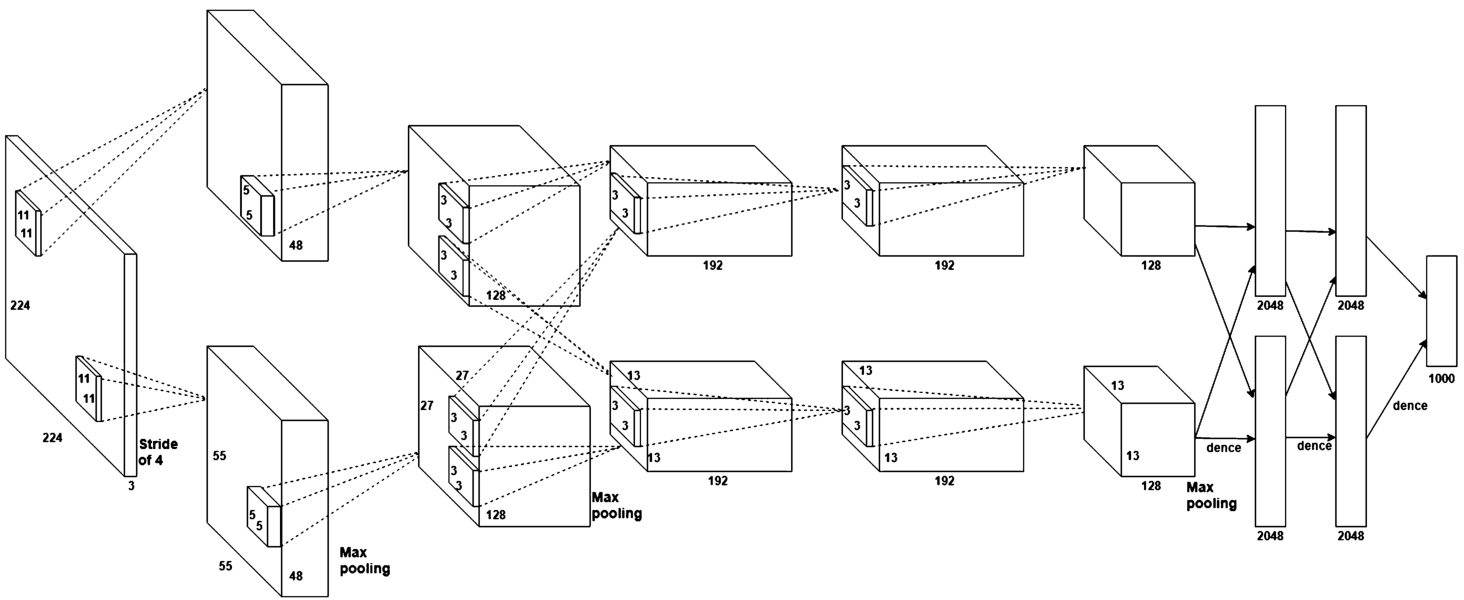

In [1]:
import os.path
import pickle
import numpy as np
from PIL import Image

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms

In [2]:
class CIFAR10Dataset(Dataset):
    base_folder = 'cifar-10-batches-py'
    train_list = ['data_batch_' + str(i+1) for i in range(5)]
    test_list = ['test_batch',]
    meta = 'batches.meta'
    
    def __init__(
        self,
        root = './',
        train = True,
        transform = None,
        target_transform = None,
    ):
        super().__init__()
        self.root = root
        self.train = train  # training set or test set
        self.transform = transform
        self.target_transform = target_transform
        if self.train:
            file_list = self.train_list
        else:
            file_list = self.test_list
        self.data = []
        self.targets = []
        
        for file_name in file_list:
            file_path = os.path.join(root, self.base_folder, file_name)
            with open(file_path, "rb") as f:
                entry = pickle.load(f, encoding='bytes')
                self.data.append(entry[b'data'])
                self.targets.extend(entry[b'labels'])
        
        self.data = np.vstack(self.data).reshape(-1, 3, 32, 32)
        self.data = self.data.transpose((0, 2, 3, 1))  # convert to HWC(Height, Width, Channel) 
        
        meta_path = os.path.join(self.root, self.base_folder, self.meta)
        with open(meta_path, "rb") as f:
            label = pickle.load(f, encoding='bytes')
            self.classes = [_class.decode('utf-8') for _class in label[b'label_names']]
        self.class_to_idx = {_class: i for i, _class in enumerate(self.classes)}

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        # return a PIL Image
        img = Image.fromarray(img)
        
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        
        return img, target
    
    def __len__(self):
        return len(self.data)

In [3]:
transform = transforms.Compose(
    [transforms.Resize(224),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 256

trainset = CIFAR10Dataset(root='./', train=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = CIFAR10Dataset(root='./', train=False, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes =trainset.classes

In [4]:
class AlexNet(nn.Module):
    in_channels = 3
    conv_kernel = 5
    pool_kernel = 2
    num_classes = 10
    def __init__(self):
        super(AlexNet, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        dropout = 0.5
        self.gpu1 = nn.Sequential(
            nn.Conv2d(3, 48, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(48, 128, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(128, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.gpu2 = nn.Sequential(
            nn.Conv2d(3, 48, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(48, 128, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(128, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, self.num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_gpu1 = self.gpu1(x)
        x_gpu2 = self.gpu2(x)
        x = torch.cat((x_gpu1,x_gpu2),1)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


alexnet = AlexNet()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
alexnet.to(device)

cuda:0


AlexNet(
  (gpu1): Sequential(
    (0): Conv2d(3, 48, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(48, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(192, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (gpu2): Sequential(
    (0): Conv2d(3, 48, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilati

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet.parameters(), lr=0.0001)

In [6]:
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    tmp_num = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = alexnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        tmp_num = tmp_num + 1
    print(f'[Epoch: {epoch + 1}] loss: {running_loss / tmp_num:.3f}')
print('Finished Training')

[Epoch: 1] loss: 1.722
[Epoch: 2] loss: 1.319
[Epoch: 3] loss: 1.131
[Epoch: 4] loss: 0.977
[Epoch: 5] loss: 0.865
[Epoch: 6] loss: 0.770
[Epoch: 7] loss: 0.703
[Epoch: 8] loss: 0.638
[Epoch: 9] loss: 0.579
[Epoch: 10] loss: 0.525
Finished Training


In [7]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = alexnet(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')

Accuracy of the network on the 10000 test images: 76.07 %


In [8]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = alexnet(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: airplane is 74.8 %
Accuracy for class: automobile is 81.9 %
Accuracy for class: bird  is 65.2 %
Accuracy for class: cat   is 58.2 %
Accuracy for class: deer  is 75.2 %
Accuracy for class: dog   is 66.8 %
Accuracy for class: frog  is 86.1 %
Accuracy for class: horse is 84.3 %
Accuracy for class: ship  is 82.0 %
Accuracy for class: truck is 87.4 %


: 